In [1]:
%load_ext autoreload
%autoreload 2
from baseline.Renderer.fast_stroke_gen import *
# import baseline.Renderer.stroke_gen as stroke_gen
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline 
import matplotlib.pyplot as plt
import itertools
import scipy.signal

In [4]:
def make_random_drawing(**kwargs):
    f = np.random.uniform(0, 1, 10)
    drawing = stroke_gen.draw(f, **kwargs)
    return f, drawing

In [2]:
def get_gaussian_filter(sigma):
    x = torch.arange(start=-1, end=2, dtype=torch.float32)
    y = torch.arange(start=-1, end=2, dtype=torch.float32)
    grid_x, grid_y = torch.meshgrid(x, y)
    result = torch.exp(-(grid_x**2 + grid_y**2)/2/sigma**2)
    return result/torch.sum(result)
    
def fast_draw(stroke, width=128):
    def scale_to_width(x, width):
        return (int)(x * (width - 1) + 0.5) # add 0.5 to be in the "middle", though I doubt this makes significant difference
    x0, y0, x1, y1, x2, y2, z0, z2, w0, w2 = stroke
    # compute 
    x1 = x0 + (x2 - x0) * x1
    y1 = y0 + (y2 - y0) * y1
    x0 = scale_to_width(x0, width)
    x1 = scale_to_width(x1, width)
    x2 = scale_to_width(x2, width)
    y0 = scale_to_width(y0, width)
    y1 = scale_to_width(y1, width)
    y2 = scale_to_width(y2, width)
    
    z0 = (int)(1 + z0 * width // 4)
    z2 = (int)(1 + z2 * width // 4)
#     print(w0, w2)
    canvas = np.zeros([width, width], dtype='float32')
    tmp = 1. / 100
    x_coord, y_coord = np.meshgrid(np.arange(width), np.arange(width))
    for i in range(100):
        t = i * tmp
        x = (int)((1-t) * (1-t) * x0 + 2 * t * (1-t) * x1 + t * t * x2)
        y = (int)((1-t) * (1-t) * y0 + 2 * t * (1-t) * y1 + t * t * y2)
        z = (int)((1-t) * z0 + t * z2)
        w = (1-t) * w0 + t * w2
        in_circle = (x - y_coord)**2 + (y - x_coord)**2 < z**2
        canvas[in_circle] = w
#         print(w)
#         cv2.circle(canvas, (y, x), z, w, -1) # observe x,y are swapped. this... really shouldn't make a difference. 
    blur_kernel = get_gaussian_filter(0.5)[None, None, :, :]
    canvas = F.conv2d(torch.tensor(np.expand_dims(canvas, axis=(0,1))), blur_kernel).squeeze()
    return 1 - canvas

NameError: name 'stroke_gen' is not defined

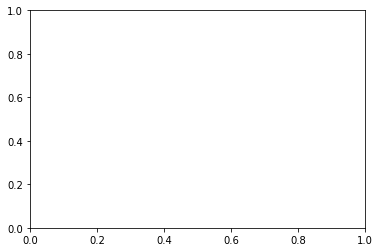

<Figure size 1200x800 with 0 Axes>

In [6]:
num_examples = 1
fig, axs = plt.subplots(num_examples,1, squeeze=False)
plt.figure(figsize=(6,4), dpi=200)\
# plt.tight_layout()
for (i,j) in itertools.product(range(num_examples), range(1)):
    f, drawing = make_random_drawing(width=128, show_points = False)
    ax = axs[i,j]
#     ax.set_title(f"params:{f}")
    ax.imshow(drawing)

In [196]:
np.min(drawing)

0.46465427

In [17]:
net = train_renderer.FCN()
train_renderer.load_weights(net, "renderer.pkl")

NameError: name 'train_renderer' is not defined

In [7]:
def test_model(stroke):
    return net(stroke)

In [3]:
fast_stroke = FastStrokeGenerator(2, 128).to(torch.device("cuda"))

In [8]:
strokes = fast_stroke.generate_strokes()
images = fast_stroke(strokes)

In [9]:
print(strokes)
rand_stroke = strokes.cpu().numpy()[0, ...]
print(rand_stroke)
# draw_result = stroke_gen.draw(rand_stroke)
fast_draw_result = fast_draw(rand_stroke)
# model_result = test_model(torch.tensor(rand_stroke).float()).detach().squeeze().numpy()
fast_stroke_result = images.cpu().numpy()[0, ...]

tensor([[0.7982, 0.9225, 0.7983, 0.8958, 0.1398, 0.3979, 0.1656, 0.8721, 0.8599,
         0.8270],
        [0.4418, 0.1025, 0.5823, 0.7481, 0.2067, 0.9548, 0.6089, 0.4862, 0.0032,
         0.7121]])
[0.79815626 0.92253256 0.79829425 0.8958415  0.13980448 0.3978886
 0.16558874 0.8720935  0.85986364 0.8270367 ]


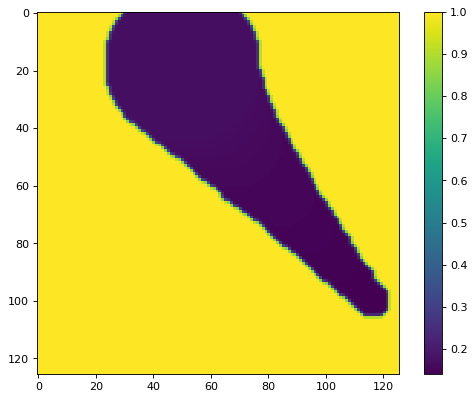

In [10]:
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(fast_draw_result)
plt.colorbar()
plt.show()

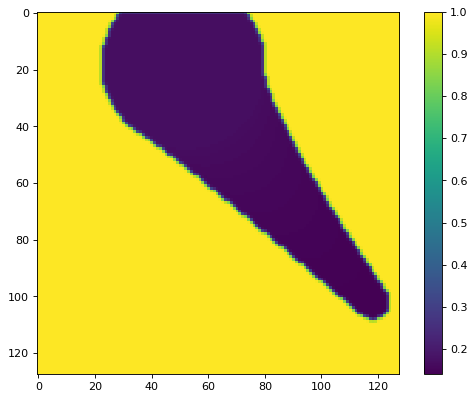

In [11]:
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(fast_stroke_result)
plt.colorbar()
plt.show()

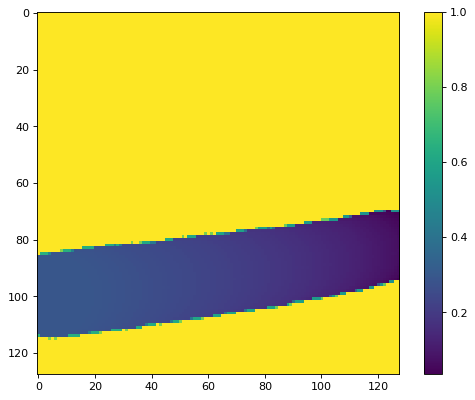

In [10]:
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(draw_result)
plt.colorbar()
plt.show()

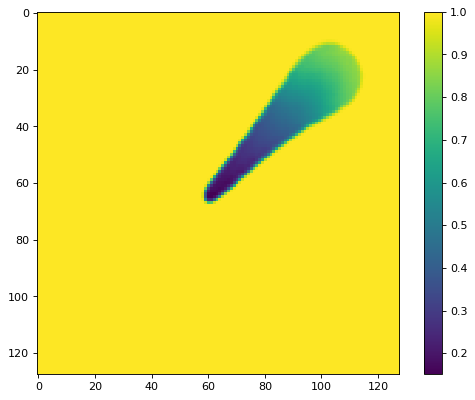

In [192]:
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(model_result)
plt.colorbar()
plt.show()

In [126]:
np.max(fast_draw_result)

1.0

In [1]:
a = torch.arange(4).reshape(2,2,1)
print(a.repeat((1,1)))
b = torch.arange(16).reshape(2,2,4)
print(b)
a - b

NameError: name 'torch' is not defined